## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [17]:
import pickle
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [18]:
# Define a function to generate mtx and dist
def cal_undist_params(read_path='camera_cal', out_path='output_images'):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # prepare object points, eg: (0,0,0,), (1,0,0), (2,0,0)
    objp = np.zeros((6*9,3), np.float32)
    objp [:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

    for file_name in os.listdir(read_path):
        # Read in each image in camera_cal folder
        image = mpimg.imread(os.path.join(read_path , file_name))
        # Convert to grayscale
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    # Calibrate each image
    for file_name in os.listdir(read_path):
        # Read in each image in camera_cal folder
        image = mpimg.imread(os.path.join(read_path , file_name))
        out_image = np.copy(image)
        gray_out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2GRAY)
        # Perform the camera calibration
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_out_image.shape[::-1], None, None)
        # Undistort image
        undist = cv2.undistort(gray_out_image, mtx, dist, None, mtx)
        # Write to output folder
        cv2.imwrite(os.path.join(out_path , file_name), undist)
        
        
    return mtx, dist


## 2. Apply a distortion correction to raw images.

In [19]:
mtx, dist = cal_undist_params('camera_cal', 'output_images')

def undist_img_in_folder(mtx, dist, read_path='test_images', out_path='output_images'):
    for file_name in os.listdir(read_path):
        undist = undist_single_img(mtx, dist, file_name, out_path)
    return 
     
def undist_single_img(mtx, dist, file_name, out_path='output_images'):
    # Read in each image in camera_cal folder
    image = mpimg.imread(file_name)
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Write to output folder
    cv2.imwrite(os.path.join(out_path , file_name), undist)
    
    return undist
       

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [51]:
# Calculate directional gradient and apply threshold
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, threshold=(20, 100)):
    thresh_min = threshold[0]
    thresh_max = threshold[1]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
            
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary

# Calculate gradient magnitude and apply threshold
def mag_thresh(image, sobel_kernel=9, mag_threshold=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    abs_sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = (255*gradmag/np.max(gradmag)).astype(np.uint8) 

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_threshold[0]) & (scaled_sobel <= mag_threshold[1])] = 1
    
    return mag_binary

# Calculate gradient direction and apply threshold
def dir_threshold(image, sobel_kernel=3, threshold=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately and take the absolute value of them
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely, sobelx)

    #Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= threshold[0]) & (absgraddir <= threshold[1])] = 1
    
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def hls_select(image, threshold=(170, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Apply a threshold to the S channel
    color_binary = np.zeros_like(S)
    color_binary[(S > threshold[0]) & (S <= threshold[1])] = 1
    
    return color_binary

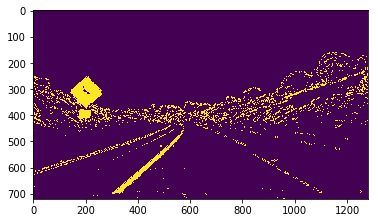

In [91]:
file_name = 'test_images/test2.jpg'
# Undistort raw images
undist = correct_single_img(mtx, dist, file_name, 'output_images')

def pipeline(undist, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(undist)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 9

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, threshold=(20, 100))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, threshold=(20, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_threshold=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, threshold=(0.7, 1.3))
    color_binary = hls_select(undist, threshold=(150, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | color_binary == 1 ] = 1

    return combined

combined = pipeline(undist, (170, 255), (20, 100))
plt.imshow(combined)



## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [118]:
def warp(image):
    image_size = (image.shape[1], image.shape[0])
    imshape = image.shape

    src = np.float32([[1180,720],[700, 440], [570, 440], [260,720]])
    dst = np.float32([[1280,720],[1280,0],[0,0],[0,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)

    return warped

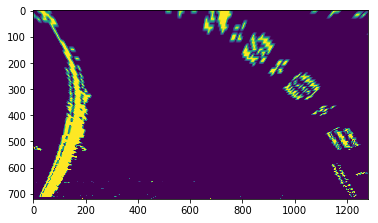

In [119]:
warped = warp(combined)
plt.imshow(warped)
